In [1]:
#from google.colab import files, drive
#drive.mount('/content/drive')

In [2]:
#!pip install -r ./drive/MyDrive/Hate_detection/Hinglish_Hate_Detection/requirements.txt

In [3]:

from __future__ import absolute_import

import sys
import os

#sys.path.append('./drive/MyDrive/Hate_detection/Hinglish_Hate_Detection/')


In [4]:
#!wandb login

In [5]:
from __future__ import absolute_import

import sys
import os

import shutil

try:
    from dotenv import find_dotenv, load_dotenv
except:
    pass

import argparse

#try:
#    sys.path.append(os.path.join(os.path.dirname(__file__), './drive/MyDrive/Hate_detection/Hinglish_Hate_Detection/'))
#except:
#    sys.path.append(os.path.join(os.getcwd(), './drive/MyDrive/Hate_detection/Hinglish_Hate_Detection/'))
    
try:
    sys.path.append(os.path.join(os.path.dirname(__file__), '../'))
except:
    sys.path.append(os.path.join(os.getcwd(), '../'))
    
import pandas as pd
import numpy as np

import pickle
from collections import Counter
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras.backend as K
#import tensorflow_addons as tfa

try:
    import wandb
    load_dotenv(find_dotenv())
    wandb.login(key=os.environ['WANDB_API_KEY'])
    from wandb.keras import WandbCallback
    _has_wandb = True
except:
    _has_wandb = False

import tokenizers
from transformers import TFAutoModel, AutoTokenizer, AutoConfig, BertTokenizer

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from src import data, models

pd.options.display.max_colwidth = -1

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING Calling wandb.login() without arguments from jupyter should prompt you for an api key.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/victor/.netrc
wandb: WARNING Unable to patch tensorflow.keras for use with W&B.  You will not be able to log images unless you set the generator argument of the callback.
/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [6]:
print (_has_wandb)

True


In [7]:
parser = argparse.ArgumentParser(prog='Trainer',conflict_handler='resolve')

#parser.add_argument('--train_data', type=str, default='./drive/MyDrive/Hate_detection/Hinglish_Hate_Detection/data/raw/Hate-speech-dataset/hate_speech.tsv', required=False,
#                    help='train data')

parser.add_argument('--train_data', type=str, default='../data/raw/Hate-speech-dataset/hate_speech.tsv', required=False,
                    help='train data')

parser.add_argument('--val_data', type=str, default=None, required=False,
                    help='validation data')
parser.add_argument('--test_data', type=str, default=None, required=False,
                    help='test data')

parser.add_argument('--transformer_model_pretrained_path', type=str, default='bert-base-multilingual-cased', required=False,
                    help='transformer model pretrained path or huggingface model name')
parser.add_argument('--transformer_config_path', type=str, default='bert-base-multilingual-cased', required=False,
                    help='transformer config file path or huggingface model name')
parser.add_argument('--transformer_tokenizer_path', type=str, default='bert-base-multilingual-cased', required=False,
                    help='transformer tokenizer file path or huggingface model name')

parser.add_argument('--max_text_len', type=int, default=50, required=False,
                    help='maximum length of text')
parser.add_argument('--max_char_len', type=int, default=200, required=False,
                    help='maximum length of text')
parser.add_argument('--max_word_char_len', type=int, default=20, required=False,
                    help='maximum length of text')

parser.add_argument('--emb_dim', type=int, default=128, required=False,
                    help='maximum length of text')
parser.add_argument('--n_layers', type=int, default=2, required=False,
                    help='maximum length of text')
parser.add_argument('--n_units', type=int, default=128, required=False,
                    help='maximum length of text')

parser.add_argument('--epochs', type=int, default=500, required=False,
                    help='number of epochs')
parser.add_argument('--lr', type=float, default=.001, required=False,
                    help='learning rate')
parser.add_argument('--early_stopping_rounds', type=int, default=50, required=False,
                    help='number of epochs for early stopping')
parser.add_argument('--lr_schedule_round', type=int, default=30, required=False,
                    help='number of epochs for learning rate scheduling')

parser.add_argument('--train_batch_size', type=int, default=16, required=False,
                    help='train batch size')
parser.add_argument('--eval_batch_size', type=int, default=8, required=False,
                    help='eval batch size')

#parser.add_argument('--model_save_path', type=str, default='./drive/MyDrive/Hate_detection/Hinglish_Hate_Detection/models/hate_detection/', required=False,
#                    help='seed')

parser.add_argument('--model_save_path', type=str, default='../models/hate_detection/', required=False,
                    help='seed')

parser.add_argument('--wandb_logging', type=bool, default=True, required=False,
                    help='wandb logging needed')

parser.add_argument('--seed', type=int, default=42, required=False,
                    help='seed')


args, _ = parser.parse_known_args()

In [8]:
tf.random.set_seed(args.seed)
np.random.seed(args.seed)

In [9]:
df = pd.read_csv(args.train_data, sep='\t',header=None,usecols=[0,1])
df.columns = ['text','category']
df = df.dropna()
df = df[df.text != '']

kf = KFold(n_splits=5, shuffle=True, random_state=args.seed)
for train_index, test_index in kf.split(df.text):
    break

train_df = df.iloc[train_index]
kf2 = KFold(n_splits=2, shuffle=True, random_state=args.seed)
for val_index, test_index in kf2.split(df.iloc[test_index].text):
    break

val_df = df.iloc[val_index]
test_df = df.iloc[test_index]

In [10]:
print (train_df.shape, val_df.shape, test_df.shape)

(3662, 2) (458, 2) (458, 2)


In [11]:
train_df.head(5)

,text,category
0,"Knowing ki Vikas kitna samjhata hai Priyanka aur Itch Guard Luv ko, usne bola tha Ben wali baat me ab Sallu ne bhi agree kiya!",no
1,I am Muhajir .. Aur mere lye sab se Pehly Pakistan he .. agr 10 lakh Altaf Jese leaders bh is zameen ki behurmati kren un sbko sar e aam phansi Deni chahye .. Proud to be a #Muhajir and #Pakistani,no
2,"Doctor sab sahi me ke PhD (in hate politics) wale. Bhai padhe likhe ho fir kyu ye sab baate karte ho. Tum bas bowling khelo, aur maje lo. pic.twitter.com/fk1qUbQstw",no
3,"Poore Desh me Patel OBC me aate Hain sirf gujrat Ko chor kar may be, ye manuwadiyon bramanwadi kabhi aapko aarackchan nahi denge ye to jis OBC Ko Mila hai usse bhi nafrat karte hain ye khoon aur chamdi ka frak karne waale bharmhanwadi kisi ke sage nahi hain",no
4,"Sarkar banne ke bad Hindu hit me ek bhi faisla Jo bjp ke dwara liya gaya ho,bjp ko gay,gobar,mandir,masjid aur nafrat faila kar vot chahiye",yes


In [12]:
train_df.text = train_df.text.apply(lambda x: data.preprocessing.clean_tweets(x))
val_df.text = val_df.text.apply(lambda x: data.preprocessing.clean_tweets(x))
test_df.text = test_df.text.apply(lambda x: data.preprocessing.clean_tweets(x))

/Users/victor/.local/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [13]:
train_df = train_df[train_df.text != '']
val_df = val_df[val_df.text != '']
test_df = test_df[test_df.text != '']


In [14]:
train_df.text.apply(lambda x: len(x)).describe()

count    3661.000000
mean     102.369571 
std      53.175251  
min      6.000000   
25%      63.000000  
50%      99.000000  
75%      130.000000 
max      313.000000 
Name: text, dtype: float64

In [15]:
train_df.text.apply(lambda x: len(x.split())).describe()

count    3661.000000
mean     19.663207  
std      10.279373  
min      1.000000   
25%      12.000000  
50%      19.000000  
75%      25.000000  
max      64.000000  
Name: text, dtype: float64

In [16]:
model_save_dir = args.model_save_path

try:
    os.makedirs(model_save_dir)
except OSError:
    pass

In [17]:
train_df.category.value_counts()

no     2316
yes    1342
on     2   
n      1   
Name: category, dtype: int64

In [18]:
train_df = train_df[train_df.category.str.contains('yes|no')]
val_df = val_df[val_df.category.str.contains('yes|no')]
test_df = test_df[test_df.category.str.contains('yes|no')]


In [19]:
model_save_dir

'../models/hate_detection/'

In [20]:
train_df.category, label2idx = data.data_utils.convert_categorical_label_to_int(train_df.category.values, \
                                                         save_path=os.path.join(model_save_dir,'label2idx.pkl'))

val_df.category, _ = data.data_utils.convert_categorical_label_to_int(val_df.category.values, \
                                                         save_path=os.path.join(model_save_dir,'label2idx.pkl'))

test_df.category, _ = data.data_utils.convert_categorical_label_to_int(test_df.category.values, \
                                                         save_path=os.path.join(model_save_dir,'label2idx.pkl'))

In [21]:
train_df.head(5)

,text,category
0,"knowing ki vikas kitna samjhata hai priyanka aur itch guard luv ko, usne bola tha ben wali baat me ab sallu ne bhi agree kiya!",0
1,i am muhajir .. aur mere lye sab se pehly pakistan he .. agr lakh altaf jese leaders bh is zameen ki behurmati kren un sbko sar e aam phansi deni chahye .. proud to be a and,0
2,"doctor sab sahi me ke phd (in hate politics) wale. bhai padhe likhe ho fir kyu ye sab baate karte ho. tum bas bowling khelo, aur maje lo. pic.twitter.com/fkqubqstw",0
3,"poore desh me patel obc me aate hain sirf gujrat ko chor kar may be, ye manuwadiyon bramanwadi kabhi aapko aarackchan nahi denge ye to jis obc ko mila hai usse bhi nafrat karte hain ye khoon aur chamdi ka frak karne waale bharmhanwadi kisi ke sage nahi hain",0
4,"sarkar banne ke bad hindu hit me ek bhi faisla jo bjp ke dwara liya gaya ho,bjp ko gay,gobar,mandir,masjid aur nafrat faila kar vot chahiye",1


In [22]:
print (label2idx)

{'no': 0, 'yes': 1}


In [23]:
idx2label = {i:w for (w,i) in label2idx.items()}

### Learn tokenizer

In [24]:
#data.custom_tokenizers.custom_wp_tokenizer(train_df.text.values, args.model_save_path, args.model_save_path)
tokenizer = BertTokenizer.from_pretrained(args.model_save_path)
#tokenizer = AutoTokenizer.from_pretrained(args.transformer_tokenizer_path)

In [25]:
word_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=50000, split=' ',oov_token=1)
char_tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, split='',oov_token=1)

word_tokenizer.fit_on_texts(train_df.text.values)
char_tokenizer.fit_on_texts(train_df.text.values)

In [26]:
transformer_train_inputs, _, _ = data.data_utils.compute_transformer_input_arrays(train_df, 'text', tokenizer, args.max_char_len)

word_train_inputs = word_tokenizer.texts_to_sequences(train_df.text.values)
word_train_inputs = tf.keras.preprocessing.sequence.pad_sequences(word_train_inputs, maxlen=args.max_text_len)

subword_train_inputs = np.asarray([data.data_utils.subword_tokenization(text, char_tokenizer, args.max_text_len, args.max_word_char_len) \
                        for text in tqdm(train_df.text.values)])

char_train_inputs = char_tokenizer.texts_to_sequences(train_df.text.values)
char_train_inputs = tf.keras.preprocessing.sequence.pad_sequences(char_train_inputs, maxlen=args.max_char_len)

train_outputs = data.data_utils.compute_output_arrays(train_df, 'category')

transformer_val_inputs, _, _ = data.data_utils.compute_transformer_input_arrays(val_df, 'text', tokenizer, args.max_char_len)

word_val_inputs = word_tokenizer.texts_to_sequences(val_df.text.values)
word_val_inputs = tf.keras.preprocessing.sequence.pad_sequences(word_val_inputs, maxlen=args.max_text_len)

subword_val_inputs = np.asarray([data.data_utils.subword_tokenization(text, char_tokenizer, args.max_text_len, args.max_word_char_len) \
                        for text in tqdm(val_df.text.values)])

char_val_inputs = char_tokenizer.texts_to_sequences(val_df.text.values)
char_val_inputs = tf.keras.preprocessing.sequence.pad_sequences(char_val_inputs, maxlen=args.max_char_len)

val_outputs = data.data_utils.compute_output_arrays(val_df, 'category')

transformer_test_inputs, _, _ = data.data_utils.compute_transformer_input_arrays(test_df, 'text', tokenizer, args.max_char_len)

word_test_inputs = word_tokenizer.texts_to_sequences(test_df.text.values)
word_test_inputs = tf.keras.preprocessing.sequence.pad_sequences(word_test_inputs, maxlen=args.max_text_len)

subword_test_inputs = np.asarray([data.data_utils.subword_tokenization(text, char_tokenizer, args.max_text_len, args.max_word_char_len) \
                        for text in tqdm(test_df.text.values)])

char_test_inputs = char_tokenizer.texts_to_sequences(test_df.text.values)
char_test_inputs = tf.keras.preprocessing.sequence.pad_sequences(char_test_inputs, maxlen=args.max_char_len)

test_outputs = data.data_utils.compute_output_arrays(test_df, 'category')

train_outputs = tf.keras.utils.to_categorical(train_outputs, \
                                                    num_classes=train_df.category.nunique())
val_outputs = tf.keras.utils.to_categorical(val_outputs, \
                                                    num_classes=train_df.category.nunique())
test_outputs = tf.keras.utils.to_categorical(test_outputs, \
                                                    num_classes=train_df.category.nunique())

tfidf1 = TfidfVectorizer(stop_words='english',ngram_range=(1,3), max_df=.6,min_df=2)
tfidf2 = TfidfVectorizer(analyzer='char_wb',ngram_range=(1,3), max_df=.6,min_df=2)

tfidf1.fit(train_df.text)
tfidf2.fit(train_df.text)

train_tfidf = np.hstack([tfidf1.transform(train_df.text).toarray(),tfidf2.transform(train_df.text).toarray()])
val_tfidf = np.hstack([tfidf1.transform(val_df.text).toarray(),tfidf2.transform(val_df.text).toarray()])
test_tfidf = np.hstack([tfidf1.transform(test_df.text).toarray(),tfidf2.transform(test_df.text).toarray()])


print (transformer_train_inputs.shape, subword_train_inputs.shape, word_train_inputs.shape, char_train_inputs.shape, \
       train_tfidf.shape, train_outputs.shape)
print (transformer_val_inputs.shape, subword_val_inputs.shape, word_val_inputs.shape, char_val_inputs.shape, \
       val_tfidf.shape, val_outputs.shape)
print (transformer_test_inputs.shape, subword_test_inputs.shape, word_test_inputs.shape, char_test_inputs.shape, \
       test_tfidf.shape, test_outputs.shape)


100%|██████████| 458/458 [00:00<00:00, 1115.37it/s]


(3658, 200) (3658, 50, 20) (3658, 50) (3658, 200) (3658, 18201) (3658, 2)
(457, 200) (457, 50, 20) (457, 50) (457, 200) (457, 18201) (457, 2)
(458, 200) (458, 50, 20) (458, 50) (458, 200) (458, 18201) (458, 2)


### Modeling

In [27]:
n_words = len(word_tokenizer.word_index)+1
n_chars = len(char_tokenizer.word_index)+1
n_subwords = tokenizer.vocab_size
tfidf_shape = train_tfidf.shape[1]
n_out = train_df.category.nunique()

In [28]:
from src.models.models import *

all_models = {WLSTM.__name__: WLSTM,HAN.__name__: HAN,CS_ELMO.__name__: CS_ELMO,CMSA.__name__: CMSA,
                  BERT.__name__: BERT,Transformer.__name__: Transformer}

for model_name, model_ in all_models.items():
    model = model_(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=tfidf_shape, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=args.max_char_len,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
    print (model_name, model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1542528     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 256)      263168      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 256)          394240      bidirectional[0][0]              
______________________________________________________________________________________________

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 200, 128)     9088        input_18[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 198, 128)     49280       embedding_6[0][0]                
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 66, 128)      0           conv1d_2[0][0]                   
____________________________________________________________________________________________

In [29]:
_has_wandb = False

In [30]:
!ls ../models/hate_detection/pseudo*

../models/hate_detection/pseudo_labelling_lstm_model.h5
../models/hate_detection/pseudo_labelling_transformer.h5
../models/hate_detection/pseudo_labelling_transformer_model.h5


In [31]:
loss = 'ce'
model_name = 'Transformer'
model1 = Transformer(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=tfidf_shape, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=args.max_char_len,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
model_save_path = os.path.join(args.model_save_path, '{}_{}_with_features.h5'.format(model_name, loss))

model1.load_weights(model_save_path)

model2 = Transformer(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=None, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=args.max_char_len,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
model_save_path = os.path.join(args.model_save_path, '{}_{}_without_features.h5'.format(model_name, loss))

model2.load_weights(model_save_path)

t_model = Transformer(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=None, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=args.max_char_len,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)

t_model.load_weights(os.path.join(args.model_save_path, 'pseudo_labelling_transformer_model.h5'))
                     

In [32]:
loss = 'ce'
model_name = 'HAN'
model3 = HAN(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=tfidf_shape, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=args.max_char_len,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
model_save_path = os.path.join(args.model_save_path, '{}_{}_with_features.h5'.format(model_name, loss))

model3.load_weights(model_save_path)

model4 = HAN(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=None, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=args.max_char_len,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
model_save_path = os.path.join(args.model_save_path, '{}_{}_without_features.h5'.format(model_name, loss))

model4.load_weights(model_save_path)

h_model = HAN(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=None, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=args.max_char_len,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)

h_model.load_weights(os.path.join(args.model_save_path, 'pseudo_labelling_transformer.h5'))

In [33]:
loss = 'ce'
model_name = 'WLSTM'
model5 = WLSTM(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=tfidf_shape, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=args.max_char_len,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
model_save_path = os.path.join(args.model_save_path, '{}_{}_with_features.h5'.format(model_name, loss))

model5.load_weights(model_save_path)

model6 = WLSTM(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=None, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=args.max_char_len,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
model_save_path = os.path.join(args.model_save_path, '{}_{}_without_features.h5'.format(model_name, loss))

model6.load_weights(model_save_path)

w_model = WLSTM(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=None, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=args.max_char_len,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)

w_model.load_weights(os.path.join(args.model_save_path, 'pseudo_labelling_lstm_model.h5'))

In [34]:
test_df.category = [idx2label[i] for i in test_df.category]

test_pred = model1.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs, test_tfidf])

test_df['Transformer_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]

test_pred = model3.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs, test_tfidf])

test_df['HAN_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]

test_pred = model5.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs, test_tfidf])

test_df['WLSTM_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]


In [35]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          model_name,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    
    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest',cmap=cmap) #, 
    plt.title(title)
    #plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    #print (thresh)
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm_ = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_ = np.around(cm_, decimals=2)
        #print (cm)
    else:
      cm_ = cm

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if cm_[i, j] > 0:
        if normalize:
            plt.text(j, i, "{:0.2f}".format(round(cm_[i, j],2)),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm_[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    SMALL_SIZE = 25
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 25

    #plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = "15"

    
    #plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.xlabel("")
    plt.ylabel("")
    plt.title("")

    plt.savefig('../plots/hate_{}.pdf'.format(model_name),dpi=200)
    plt.show()
    
def get_conditional_weights(text, model, class_idx):
    all_texts = [" ".join(text.split()[:i]) for i in range(len(text.split())+1)][1:]
    #all_texts = [text]*(len(text.split())+1)
    word_train_inputs = word_tokenizer.texts_to_sequences(all_texts)
    word_train_inputs = tf.keras.preprocessing.sequence.pad_sequences(word_train_inputs, maxlen=args.max_text_len)

    subword_train_inputs = np.asarray([data.data_utils.subword_tokenization(text, char_tokenizer, args.max_text_len, args.max_word_char_len) \
                            for text in all_texts])

    char_train_inputs = char_tokenizer.texts_to_sequences(all_texts)
    char_train_inputs = tf.keras.preprocessing.sequence.pad_sequences(char_train_inputs, maxlen=args.max_char_len)
    
    for i in range(len(text.split())):
        #subword_train_inputs_ = subword_train_inputs.copy()
        subword_train_inputs[i,i,:] = np.array([0]*subword_train_inputs.shape[-1])
        
    #print (subword_train_inputs[-1])
    probs = model.predict([word_train_inputs,char_train_inputs,subword_train_inputs,\
                                      char_train_inputs])
    
    #print (probs)
    #print (all_texts)
    
    probs_ = probs[-1] - probs
    #class_idx = probs.argmax(-1)[-1]
    
    return probs_[:,class_idx]

import html
from IPython.core.display import display, HTML

def html_escape(text):
    return html.escape(text)

def gradient_plots(text,weights,max_alpha=.3):
    highlighted_text = []

    for i, word in enumerate(text.split()):
        
        if i < args.max_text_len:
            weight = weights[i]

            if weight is not None:
                highlighted_text.append('<span style="background-color:rgba(135,206,250,' + str(weight / max_alpha) + ');">' + html_escape(word) + '</span>')
            else:
                highlighted_text.append(word)
            
    highlighted_text = ' '.join(highlighted_text)
    
    return highlighted_text

def plot_attention(attention, sentence,plot_size=12, filename='image.pdf'):
    fig = plt.figure(figsize=(plot_size,plot_size))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='Blues')

    fontdict = {'fontsize': 30}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=45)
    ax.set_yticklabels([''] + sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    SMALL_SIZE = 20
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 20
    
    #plt.show()
    plt.rcParams["font.family"] = 'sans-serif' #"Times New Roman"
    plt.rcParams["font.size"] = "15"

    
    #plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.xlabel("")
    plt.ylabel("")
    plt.title("")
    
    plt.savefig(filename, dpi=200)

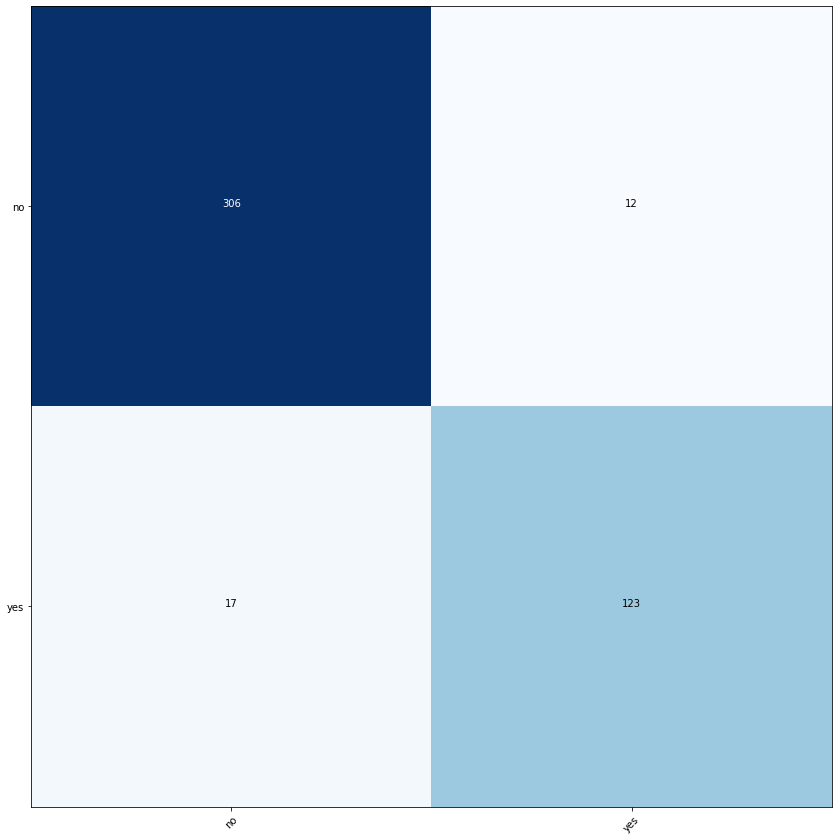

In [36]:
cm = pd.crosstab(test_df.category, test_df.Transformer_pred)
cm = cm[cm.index]
cm
plot_confusion_matrix(cm           = cm.values, 
                      normalize    = False,
                      target_names = cm.index.to_list(),
                      title        = "Confusion Matrix",
                     model_name='Transformer')

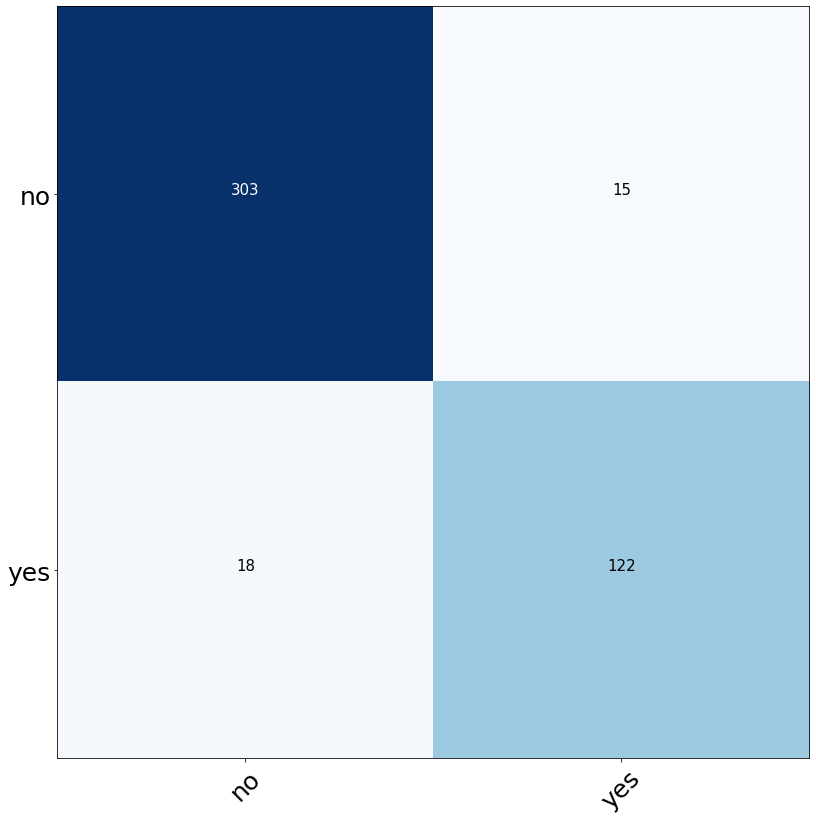

In [37]:
cm = pd.crosstab(test_df.category, test_df.HAN_pred)
cm = cm[cm.index]
cm
plot_confusion_matrix(cm           = cm.values, 
                      normalize    = False,
                      target_names = cm.index.to_list(),
                      title        = "Confusion Matrix",
                     model_name='HAN')

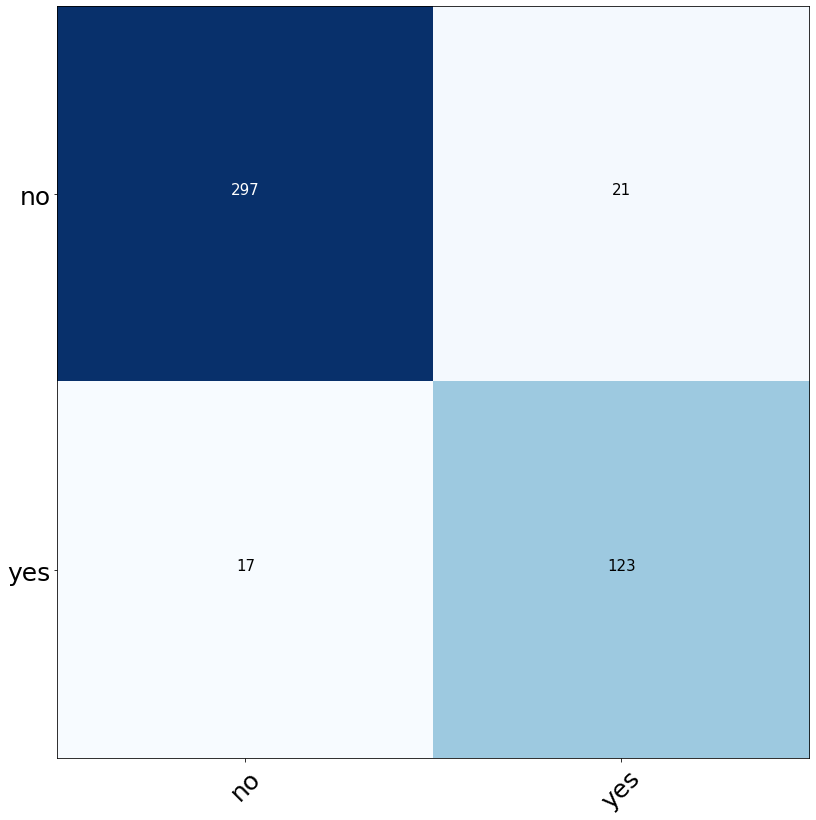

In [38]:
cm = pd.crosstab(test_df.category, test_df.WLSTM_pred)
cm = cm[cm.index]
cm
plot_confusion_matrix(cm           = cm.values, 
                      normalize    = False,
                      target_names = cm.index.to_list(),
                      title        = "Confusion Matrix",
                     model_name='WLSTM')

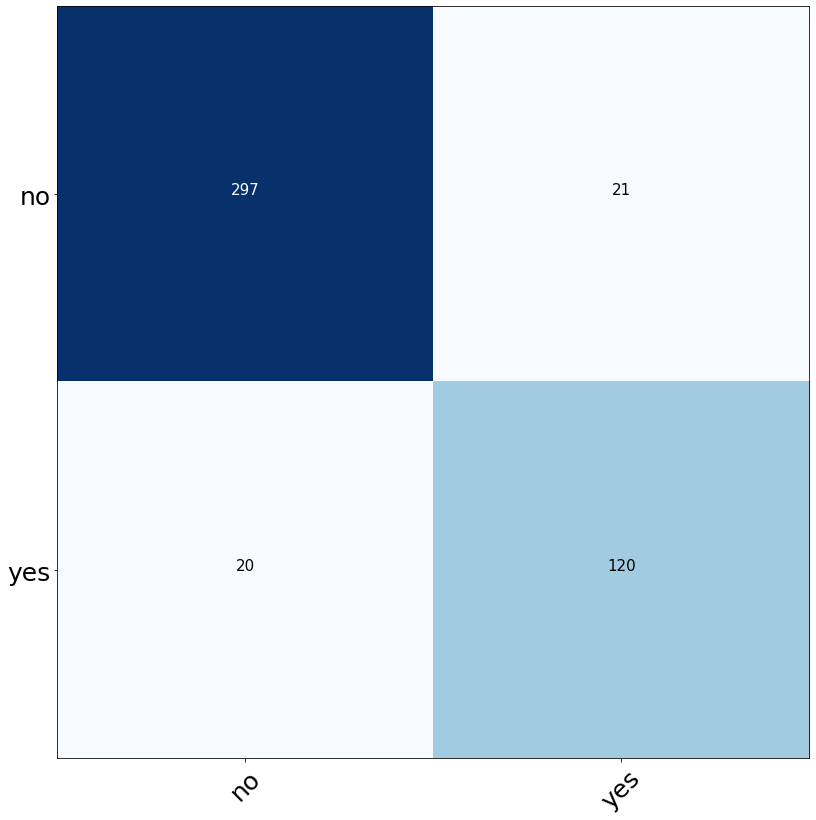

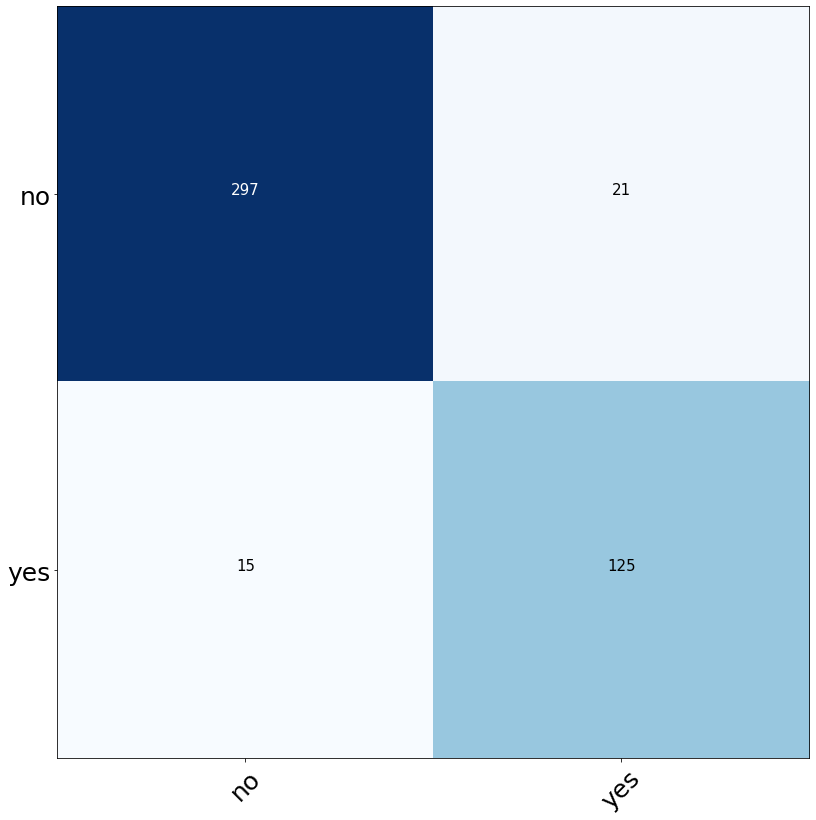

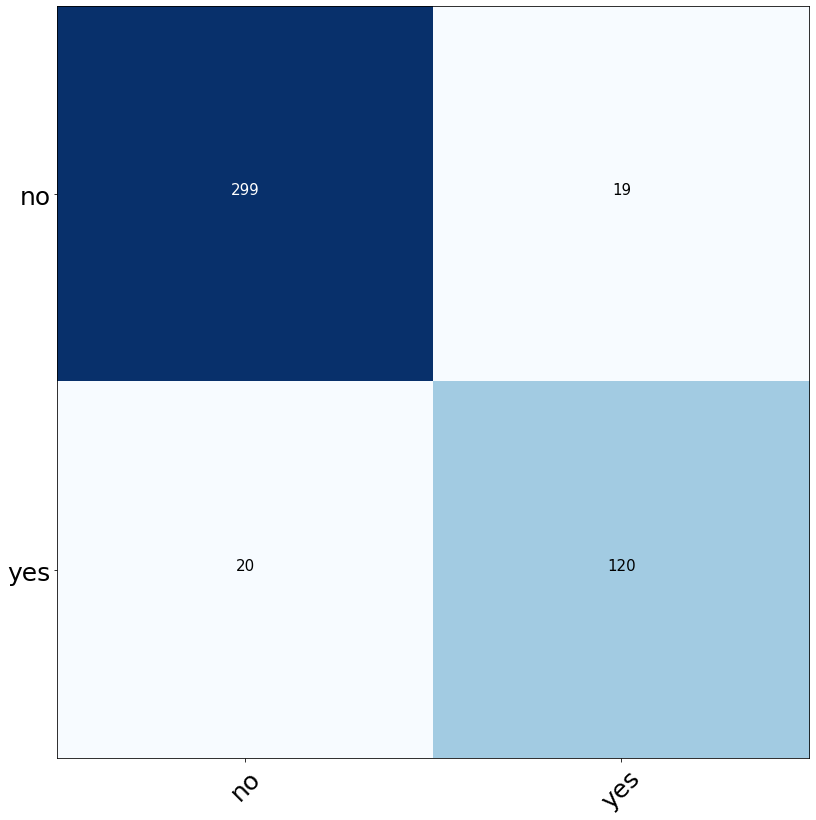

In [39]:
test_pred = t_model.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs])

test_df['Transformer_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]

test_pred = h_model.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs])

test_df['HAN_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]

test_pred = w_model.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs])

test_df['WLSTM_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]

cm = pd.crosstab(test_df.category, test_df.Transformer_pred)
cm = cm[cm.index]
cm
plot_confusion_matrix(cm           = cm.values, 
                      normalize    = False,
                      target_names = cm.index.to_list(),
                      title        = "Confusion Matrix",
                     model_name='Transformer_pl')

cm = pd.crosstab(test_df.category, test_df.HAN_pred)
cm = cm[cm.index]
cm
plot_confusion_matrix(cm           = cm.values, 
                      normalize    = False,
                      target_names = cm.index.to_list(),
                      title        = "Confusion Matrix",
                     model_name='HAN_pl')

cm = pd.crosstab(test_df.category, test_df.WLSTM_pred)
cm = cm[cm.index]
cm
plot_confusion_matrix(cm           = cm.values, 
                      normalize    = False,
                      target_names = cm.index.to_list(),
                      title        = "Confusion Matrix",
                     model_name='WLSTM_pl')


In [40]:
test_df = test_df.reset_index(drop=True)

test_pred = model2.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs])

test_df['Transformer_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]

test_pred = model4.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs])

test_df['HAN_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]

test_pred = model6.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs])

test_df['WLSTM_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]

In [41]:
test_df.tail(20)

,text,category,Transformer_pred,HAN_pred,WLSTM_pred
438,ye log babaon ke rape-jihad k khilaf kyon nahin kucchh karte hain . ye baba bahno ko apne hawash ka shikar bana rahe hai jo few neutral media reporting ki wajah se ek- karke jail ja rahe hain. ://twitter.com/thewire_in/status/ …,no,no,no,no
439,lala kal ke baud se zinda ghar wapis aye ho na bagair rape hue?,no,no,no,no
440,koi bat niiii ap k hate ko dekhta,no,no,no,no
441,atleast tumhare journalism ke gold standard ki tarah apne bhai ke rape ko toh nahi chupatey,no,no,no,no
442,"hate kisi say bhi nahi tha, sab say pyar tha wo bhi bht zyada and ab nafrat hai apnay aap say isi wajah say k q tha aisa",yes,no,no,no
443,nahi mujhe i hate u likhna tha,yes,yes,yes,yes
444,haan bhai rape toh nai hua aaj koi. par bomb toh pahte tere pakistan mein . chal bhai jab tak zinda hai twitter karle,no,no,no,no
445,waise rape se mujhe teri maa ki hai allah hai yaad hai,no,no,no,no
446,tu hamari fd ki jotish hai bahena and sacchi mein i hate neha,no,no,no,no
447,bhai hate n hater ki baat nahi.. main toh fact bol raha. mujhe unlogo se koi lena dena nahi,no,no,no,no


In [42]:
text = test_df.text.iloc[2]

highlighted_text = gradient_plots(text,get_conditional_weights(text, model2, 1))

display(HTML(highlighted_text))


In [53]:
text = "i hate takla’s all raps.  woh muh kholta hai ki usse khuch phek ke marne ka mann kartahai"

highlighted_text = gradient_plots(text,get_conditional_weights(text, model2, 0))

display(HTML(highlighted_text))

In [51]:
#text = "chutiyee ko kabhi v allow nehi karna chahiye fight me"
highlighted_text = gradient_plots(text,get_conditional_weights(text, model4, 1))

display(HTML(highlighted_text))

In [52]:
#text = "chutiyee ko kabhi v allow nehi karna chahiye fight me"
highlighted_text = gradient_plots(text,get_conditional_weights(text, model6, 1))

display(HTML(highlighted_text))

In [41]:
get_conditional_weights(text, model4, 1)

array([9.9999893e-01, 9.9995446e-01, 4.1718942e-01, 1.9228458e-03,
       7.2717667e-06, 7.5531006e-04, 3.5709989e-01, 8.5953557e-01,
       4.4872046e-02, 2.4914742e-05, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

In [42]:
text = test_df.text.iloc[32]

highlighted_text = gradient_plots(text,get_conditional_weights(text, model4, 0))

display(HTML(highlighted_text))


In [43]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def get_word_attention(text, model, tokenizer,model_name):
    df = pd.DataFrame()
    df['text'] = [text]
    transformer_val_inputs, _, _ = data.data_utils.compute_transformer_input_arrays(df, 'text', tokenizer, args.max_char_len)
    
    print (transformer_val_inputs.shape)
    
    pos = model.layers[1](transformer_val_inputs)
    embs = model.layers[2](pos)
    
    attn = model.layers[3].att
    
    batch_size = tf.shape(embs)[0]
    query = attn.query_dense(embs)  # (batch_size, seq_len, embed_dim)
    key = attn.key_dense(embs)  # (batch_size, seq_len, embed_dim)
    value = attn.value_dense(embs)  # (batch_size, seq_len, embed_dim)
    query = attn.separate_heads(
        query, batch_size
    )  # (batch_size, num_heads, seq_len, projection_dim)
    key = attn.separate_heads(
        key, batch_size
    )  # (batch_size, num_heads, seq_len, projection_dim)
    value = attn.separate_heads(
        value, batch_size
    )  # (batch_size, num_heads, seq_len, projection_dim)
    attention, weights = attn.attention(query, key, value)
    weights = weights.numpy().mean(1)[0]

    sentence = tokenizer.tokenize(text) #text.split()
    try:
        plot_attention(weights[:len(sentence),:len(sentence)],sentence,filename='../plots/attention_hate_{}.pdf'.format(model_name))
    except:
        plot_attention(weights,sentence,filename='../plots/attention_hate_{}.pdf'.format(model_name))

In [44]:
def get_word_attention_bert(text, bert_model, bert_tokenizer,filename='../plots/attention_hate_BERT.pdf'):
    
    input = np.array(bert_tokenizer.encode(text))[np.newaxis,:]

    out = bert_model(input)
    
    weights = out[-1][-1].numpy().mean(1)[0]
    
    sentence = tokenizer.tokenize(text) #text.split()
    
    try:
        plot_attention(weights[:len(sentence),:len(sentence)],sentence,filename=filename)
    except:
        plot_attention(weights,sentence,filename=filename)

In [45]:
model_name = 'BERT'
loss = 'ce'
bert_tokenizer = AutoTokenizer.from_pretrained(args.transformer_tokenizer_path)
bert_model = BERT(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=bert_tokenizer.vocab_size, vectorizer_shape=tfidf_shape, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=args.max_char_len,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
model_save_path = os.path.join(args.model_save_path, '{}_{}_with_features.h5'.format(model_name, loss))
bert_model.load_weights(model_save_path)

base_model = bert_model.layers[1]
base_model.save_pretrained('./')

config = AutoConfig.from_pretrained(args.transformer_config_path, output_attentions=True)

base_model = TFAutoModel.from_pretrained('./', config=config)


100%|██████████| 1/1 [00:00<00:00, 822.41it/s]
/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator


(1, 200)


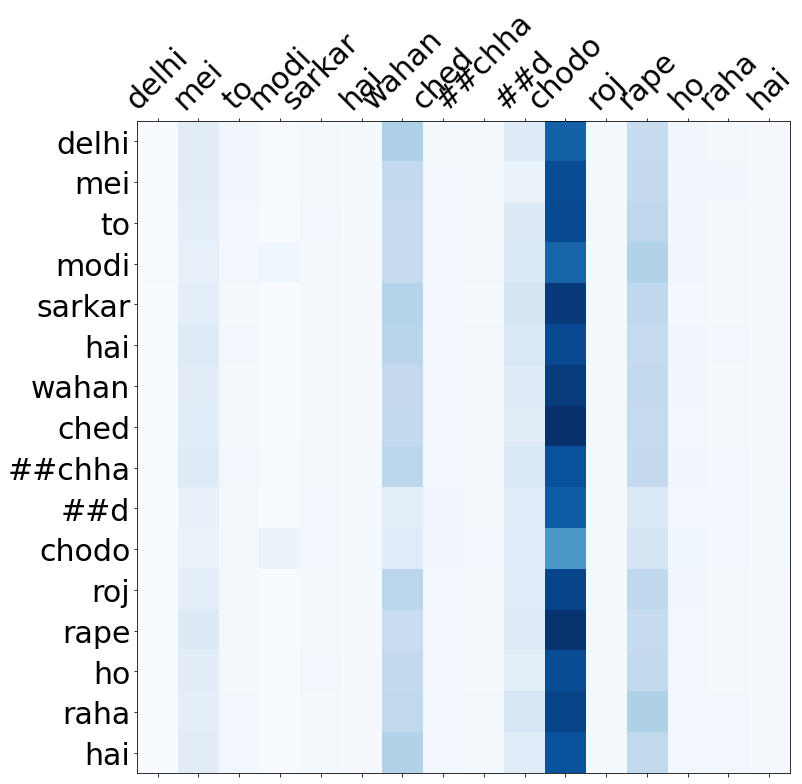

In [47]:
get_word_attention(test_df.text.iloc[450], model1, tokenizer, 'Transformer')

/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator


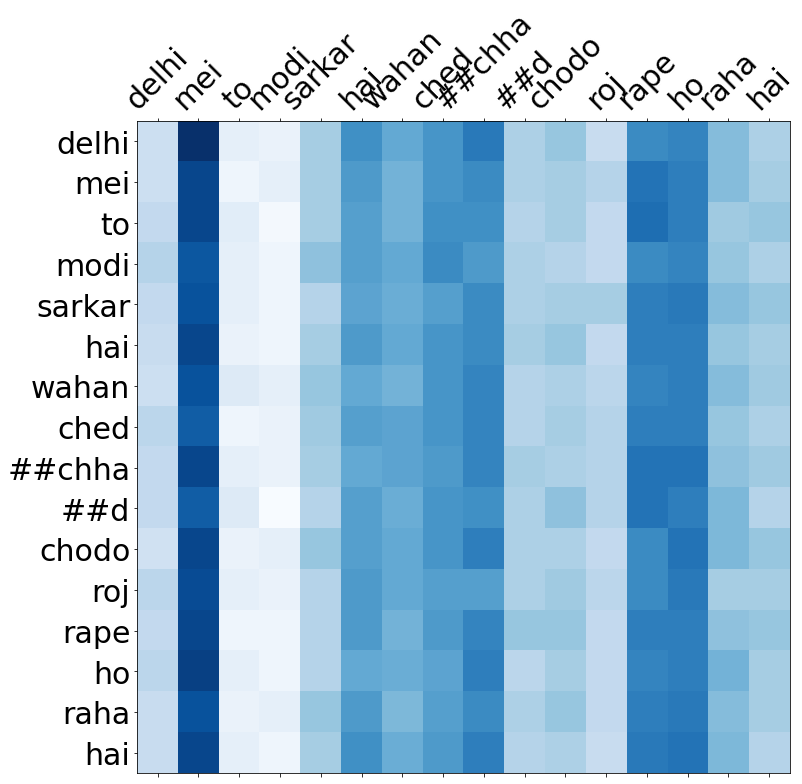

In [48]:
get_word_attention_bert(test_df.text.iloc[450], base_model, bert_tokenizer)